## Machine Learning to Predict Booking Cancellation

#### Steps:
- Select some valuable and relevant features to our analysis by checking the correlation.
- Encode some categorical features.
- Split dataset to train data and test data.
- Predict the data by using LogisticRegression, KNNeighbors, and RandomForestClassifier.
- Compare models and select the best.
- Hyperparameter tuning the best default model.
- Compare the results.
- Deploy model.

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, roc_curve, recall_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
bookings = pd.read_csv('data_cleaned.csv')

### Feature Selection

In [3]:
df_le = bookings.copy()

In [4]:
le = LabelEncoder()
cats = [
    'hotel',
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'customer_type',
    'reservation_status',
    'reservation_status_date',
    'arrival_year_month'
    ]

for feature in cats:
    df_le[feature] = le.fit_transform(df_le[feature])

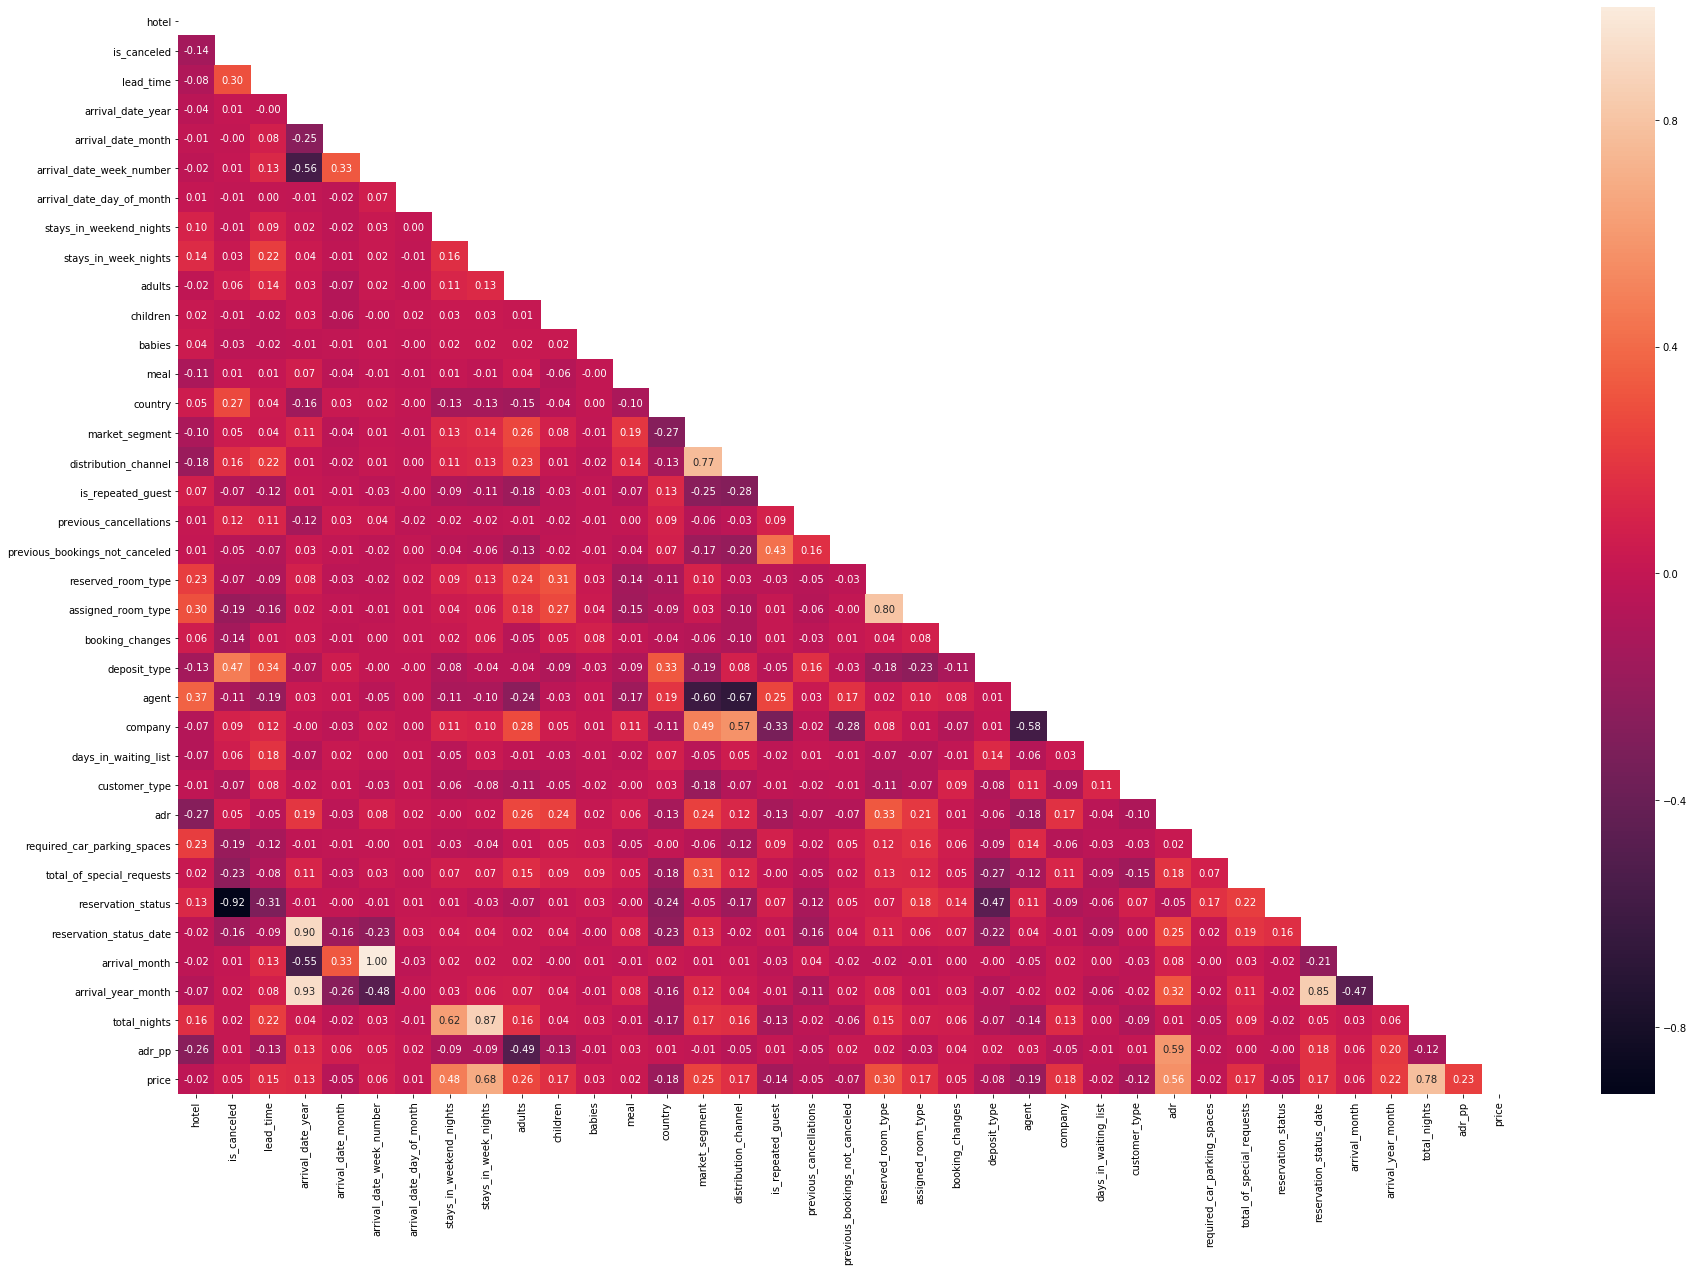

In [5]:
plt.figure(figsize = (30,20))
matrix = np.triu(df_le.corr())
sns.heatmap(df_le.corr(), annot=True, mask=matrix, fmt='.2f')

In matrix above, there appears to be a negative high correlation between **_reservation_status_** and **_is_canceled_** features. There is also a high correlation between **_total_nights_** and **_stays_in_week_nights_** and **_stays_in_weekend_nights_** fields. So, we remove **_reservation_status_** and **_total_nights_** features from our data set. Since there is a relation between **_reservation_status_date_** and **_reservation_status_**, we will remove this feature.

We also remove **_adr_pp_** & **_arrival_year_month_** since we don't need that feature after we did some exploratory analysis before.

In [6]:
cols = [
    'reservation_status',
    'total_nights',
    'reservation_status_date',
    'adr_pp',
    'arrival_year_month'
]

bookings = bookings.drop(cols, axis=1)
df_le2 = df_le.drop(cols, axis=1)

#### Selecting feature based on importances

In [7]:
X_feat = df_le2.drop('is_canceled', axis = 1)
y_feat = df_le2['is_canceled']

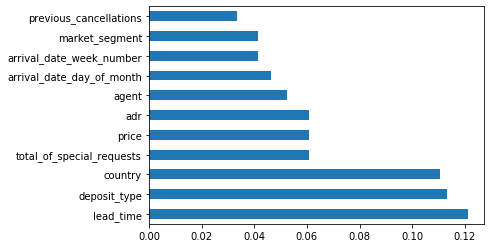

In [8]:
model = RandomForestClassifier()
model.fit(X_feat, y_feat)

feat_importances = pd.Series(model.feature_importances_, index = X_feat.columns)
feat_importances.nlargest(11).plot.barh()
plt.show()

From the plot above, we can see **_lead_time_** as the most important feature. It makes sense if we assume the longer the gap between booking time and arrival time, the higher chance a guest will cancel the reservation. Because many events may occur more and influence the guests's decision.

The **_price_** and **_adr_** feature seems having the same importances. I will choose the **_price_** feature because it defines the total price the guest should pay, while the **_adr_** only defines the average rate.

I also will drop **_agent_** feature because it only shows the ID number of the each intermediaries, and it's a lot. 

In [9]:
selected = df_le2[[
    'is_canceled',
    'deposit_type',
    'lead_time',
    'country',
    'price',
    'total_of_special_requests',
    'arrival_date_day_of_month',
    'arrival_date_week_number',
    'market_segment',
    'previous_cancellations'
]]

In [10]:
selected.head()

,is_canceled,deposit_type,lead_time,country,price,total_of_special_requests,arrival_date_day_of_month,arrival_date_week_number,market_segment,previous_cancellations
0,0,0,7,57,75.0,0,1,27,3,0
1,0,0,13,57,75.0,0,1,27,2,0
2,0,0,14,57,196.0,1,1,27,6,0
3,0,0,14,57,196.0,1,1,27,6,0
4,0,0,0,133,214.0,0,1,27,3,0


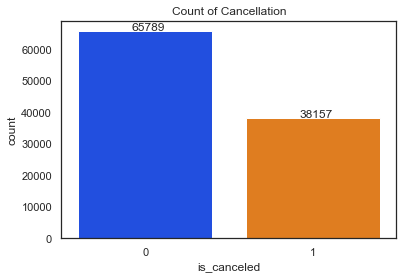

In [11]:
sns.set(style = 'white')
plt.title('Count of Cancellation', fontdict = {'fontsize': 12})
ax = sns.countplot(x='is_canceled', data=selected, palette='bright')
for p in ax.patches:
    ax.annotate((p.get_height()),(p.get_x()+0.32 , p.get_height()+100))

### Handling Imbalanced Data

From the boxplot above, seems like number of cancellation and number of success reservations are still imbalance. We try to balance them by downsampling the majority classes and combine it with minority classes. Let's see the code below.

#### Notes:

- Majority Class: The class (or classes) in an imbalanced classification predictive modeling problem that has many examples.
- Minority Class: The class in an imbalanced classification predictive modeling problem that has few examples.

In [12]:
# separate majority and minority classes
major = selected[selected['is_canceled'] == 0]
minor = selected[selected['is_canceled'] == 1]

# downsample majority class
downsampled = resample(major, replace=False, n_samples=len(minor), random_state=123) 

# combine minority class with downsampled majority class
df_new = pd.concat([downsampled, minor])

# display new class counts
df_new['is_canceled'].value_counts()

1    38157
0    38157
Name: is_canceled, dtype: int64

 Data of cancellation and succes reservations is already balanced.

In [13]:
X = df_new.drop('is_canceled', axis=1)
y = df_new['is_canceled']

### Split dataset into Train and Test

- Train size = .8
- Test sixe = .2

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

#### Create Class to store functions

In [15]:
class Report:
    def __init__(self, X_test, y_test):
        self.X = X_test
        self.y = y_test
    
    def metrics(self, model):
        y_pred = model.predict(self.X)
        
        print('Accuracy score:\n')
        print(accuracy_score(self.y, y_pred))
        
        print('\nConfusion Matrix:\n')
        print(confusion_matrix(self.y, y_pred))
        
        print('\nClassification Report:\n')
        print(classification_report(self.y, y_pred))
        
    def rec_score(self, model):
        y_pred = model.predict(self.X)
        
        print('Recall score:')
        print(recall_score(self.y, y_pred))
        
    def fscore(self, model):
        y_pred = model.predict(self.X)
        
        print('F1 score:')
        print(f1_score(self.y, y_pred))
    
    def plot_roc_curve(self, model, part='h1', save=False):
        probs = model.predict_proba(self.X)
        preds = probs[:, 1]

        fpr, tpr, threshold = roc_curve(self.y, preds)
        roc_auc = auc(fpr, tpr)

        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        
        if save:
            name = model.__class__.__name__
            plt.savefig(f'./images/{name}_{part}.png')
        plt.show()

In [16]:
report = Report(X_test, y_test)

### Modelling

We will use 3 classification models for our predictive Machine Learnig. Those are:
- Logistic Regression: a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.
- K-Nearest-Neighbors: a simple algorithm that stores all the available cases and classifies the new data or case based on a similarity measure. It is mostly used to classifies a data point based on how its neighbours are classified.
- Random Forest Classifier: consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction

#### 1. Logistic Regression

Accuracy score:

0.7450042586647448

Confusion Matrix:

[[6423 1260]
 [2632 4948]]

Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.84      0.77      7683
           1       0.80      0.65      0.72      7580

    accuracy                           0.75     15263
   macro avg       0.75      0.74      0.74     15263
weighted avg       0.75      0.75      0.74     15263



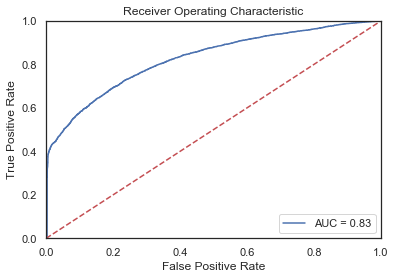

Recall score:
0.6527704485488126


F1 score:
0.717725558456629


In [17]:
log = LogisticRegression().fit(X_train, y_train)

report.metrics(log)
report.plot_roc_curve(log)
report.rec_score(log)
print('\n')
report.fscore(log)

In [18]:
log_score = cross_val_score(log, X_test, y_test, cv=10).mean()
log_trainScore = log.score(X_train, y_train)
log_testScore = log.score(X_test, y_test)

print('LogisticRegression Cross Validation Score: {}'.format(log_score))
print('LogisticRegression Train Score: {}'.format(log_trainScore))
print('LogisticRegression Test Score: {}'.format(log_testScore))

LogisticRegression Cross Validation Score: 0.7435642489363584
LogisticRegression Train Score: 0.738530081407348
LogisticRegression Test Score: 0.7450042586647448


#### 2. K-Nearest Neighbors

In [19]:
knn = KNeighborsClassifier().fit(X_train, y_train)

Accuracy score:

0.7469042783201205

Confusion Matrix:

[[5907 1776]
 [2087 5493]]

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.77      0.75      7683
           1       0.76      0.72      0.74      7580

    accuracy                           0.75     15263
   macro avg       0.75      0.75      0.75     15263
weighted avg       0.75      0.75      0.75     15263



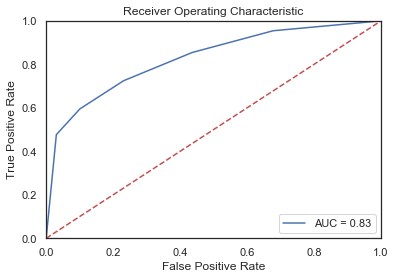

Recall score:
0.72467018469657


F1 score:
0.739847801198734


In [20]:
report.metrics(knn)
report.plot_roc_curve(knn)
report.rec_score(knn)
print('\n')
report.fscore(knn)

In [21]:
knn_score = cross_val_score(knn, X_test, y_test, cv=10).mean()
knn_trainScore = knn.score(X_train, y_train)
knn_testScore = knn.score(X_test, y_test)

print('KNN Cross Validation Score: {}'.format(knn_score))
print('KNN Train Score: {}'.format(knn_trainScore))
print('KNN Test Score: {}'.format(knn_testScore))

KNN Cross Validation Score: 0.7113281595329504
KNN Train Score: 0.8268333033037952
KNN Test Score: 0.7469042783201205


#### 3. Random Forest Classifer

In [22]:
rfc = RandomForestClassifier().fit(X_train, y_train)

Accuracy score:

0.8484570530039965

Confusion Matrix:

[[6609 1074]
 [1239 6341]]

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      7683
           1       0.86      0.84      0.85      7580

    accuracy                           0.85     15263
   macro avg       0.85      0.85      0.85     15263
weighted avg       0.85      0.85      0.85     15263



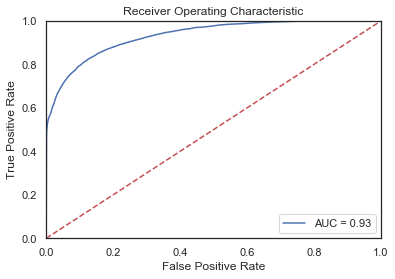

Recall score:
0.8365435356200528


F1 score:
0.8457485828609537


In [23]:
report.metrics(rfc)
report.plot_roc_curve(rfc)
report.rec_score(rfc)
print('\n')
report.fscore(rfc)

In [24]:
rfc_score = cross_val_score(rfc, X_test, y_test, cv=10).mean()
rfc_trainScore = rfc.score(X_train, y_train)
rfc_testScore = rfc.score(X_test, y_test)

print('RandomForest Cross Validation Score: {}'.format(rfc_score))
print('RandomForest Train Score: {}'.format(rfc_trainScore))
print('RandomForest Test Score: {}'.format(rfc_testScore))

RandomForest Cross Validation Score: 0.8221847719639757
RandomForest Train Score: 0.9941360501875481
RandomForest Test Score: 0.8484570530039965


In [25]:
compare_score = pd.DataFrame({'Model' : ['LogRegression', 'KNNeighbors', 'RandomForest'], 
                              'CrossVal Score': [log_score, knn_score, rfc_score],
                             'Train Score': [log_trainScore, knn_trainScore, rfc_trainScore],
                             'Test Score': [log_testScore, knn_testScore, rfc_testScore]})

compare_score.head()

,Model,CrossVal Score,Train Score,Test Score
0,LogRegression,0.743564,0.738530,0.745004
1,KNNeighbors,0.711328,0.826833,0.746904
2,RandomForest,0.822185,0.994136,0.848457


From default models above, we can see RandomForestClassifer has the best cross validation score and best model score with train & test data. Therefore, we choose it as our prediction model. Let's try tuning the hyperparameter to get the better result.

### HyperParameter tuning using GridSearchCV

In [26]:
rfc_params = {
    'max_depth': [5, 10, 15, 20],
    'max_features': [2, 3, 5],
    'n_estimators': [100, 500, 1000],
    'min_samples_split': [5, 10, 15],
}

In [27]:
from sklearn.model_selection import GridSearchCV
params = {
    'estimator': rfc,
    'param_grid': rfc_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
rfc_cv = GridSearchCV(**params)

In [28]:
model = rfc_cv.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 44.8min finished


In [29]:
model.best_params_

{'max_depth': 20,
 'max_features': 5,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [30]:
rf = RandomForestClassifier(**model.best_params_).fit(X_train, y_train)

Accuracy score:

0.84649151542947

Confusion Matrix:

[[6607 1076]
 [1267 6313]]

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      7683
           1       0.85      0.83      0.84      7580

    accuracy                           0.85     15263
   macro avg       0.85      0.85      0.85     15263
weighted avg       0.85      0.85      0.85     15263



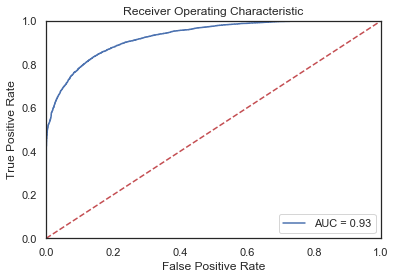

Recall score:
0.8328496042216359


F1 score:
0.843476518137484


In [31]:
report.metrics(rf)
report.plot_roc_curve(rf)
report.rec_score(rf)
print('\n')
report.fscore(rf)

In [32]:
rf_score = cross_val_score(rf, X_test, y_test, cv=10).mean()
rf_trainScore = rf.score(X_train, y_train)
rf_testScore = rf.score(X_test, y_test)

print('RandomForest Cross Validation Score: {}'.format(rf_score))
print('RandomForest Train Score: {}'.format(rf_trainScore))
print('RandomForest Test Score: {}'.format(rf_testScore))

RandomForest Cross Validation Score: 0.8228406378502809
RandomForest Train Score: 0.9499598696172052
RandomForest Test Score: 0.84649151542947


In [33]:
compare_rfc = pd.DataFrame({'Random Forest Model' : ['Default', 'Hyperparameter'], 
                            'CrossVal Score': [rfc_score, rf_score],
                           'Train Score': [rfc_trainScore, rf_trainScore],
                           'Test Score': [rfc_testScore, rf_testScore]})

compare_rfc.head()

,Random Forest Model,CrossVal Score,Train Score,Test Score
0,Default,0.822185,0.994136,0.848457
1,Hyperparameter,0.822841,0.949960,0.846492


The Cross Validation Score of tuned model is slightly better that the default one. But, we want to minimize the false negative in this case. **The higher recall score, the better**. And the default model's **recall score** is better than the tuned one. It's interesting to see, maybe we can add some parameters to get the best one for future analysis and until I get the powerful device to do so. For now, we stick to the result above and will use the default one to predict.

In [34]:
prediction = rfc.predict(X_test)

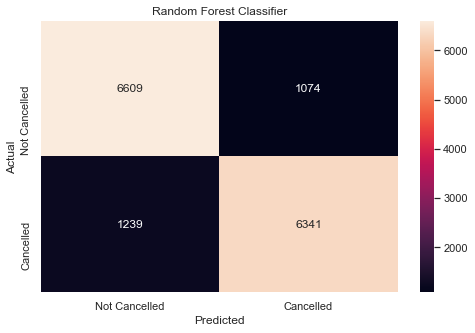

In [42]:
conf_matrix = confusion_matrix(y_test, prediction)

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", ax=ax)

labels = ['Not Cancelled', 'Cancelled']

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.title('Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Conclusion
Let's assume that we're the hotel managers. Obviously, we want to give the best service to our guests. So, the smaller False Negative (model predict cancelled, actually reservation is not cancelled) the better, therefore we choose model with the higher Recall score.

This model also can reduce cost if the result is True Negative (model predict cancelled, actually reservation is also cancelled). Because we don't need to prepare manpower, food, or other resources for the guest.

### Possible Future Work

1. Might be using other machine learning classification models, such as XGBoost, GradientBoost, etc. Also another machine learning type, such as clustering to do customer segmentation.

2. Might be tuning all paramaters for all models using GridSearchCV once I have powerful device to do so.

3. Explore all variables to see whether is possible or not to use Deep Learning while learning it.

4. From previous research, room type and booking channel are ones of the most important predictors. I will explore them more to see if those features can improve our model. Unfortunately, I can't find better explanation and data input of booking channel (agent) rather than value ID. The distribution channel feature of the dataset only defines two values that only assume all bookings made by intermediaries.

### Deploy Model

In [37]:
import joblib
joblib.dump(rfc, "modelJoblib")

['modelJoblib']

In [38]:
df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,76314.0,0.500000,0.500003,0.0,0.0,0.5,1.0,1.0
deposit_type,76314.0,0.168750,0.377739,0.0,0.0,0.0,0.0,2.0
lead_time,76314.0,102.846607,95.426424,0.0,22.0,74.0,162.0,374.0
country,76314.0,94.115601,44.196069,0.0,54.0,122.0,133.0,174.0
price,76314.0,304.247468,204.967439,1.0,150.0,260.0,400.0,1141.0
total_of_special_requests,76314.0,0.510417,0.761291,0.0,0.0,0.0,1.0,5.0
arrival_date_day_of_month,76314.0,15.788715,8.748740,1.0,8.0,16.0,23.0,31.0
arrival_date_week_number,76314.0,26.871164,13.735579,1.0,16.0,26.0,38.0,53.0
market_segment,76314.0,4.980371,1.202334,0.0,4.0,5.0,6.0,6.0
previous_cancellations,76314.0,0.115208,0.942985,0.0,0.0,0.0,0.0,26.0


In [45]:
df_new.to_csv('final_data.csv', index=False)